# This notebook uses LatSim parameters after hyperparameter tuning

Previous notebooks with LatSim do not.
This is also a more general version of LatSim.

dict_keys(['FC-slim', 'subjNum2IdxMap', 'subjIdx2NumMap', 'groupsNormalDiagMap'])


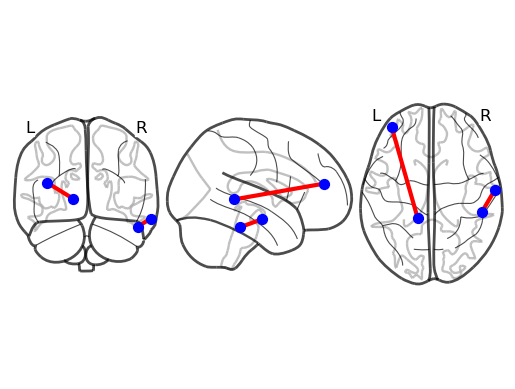

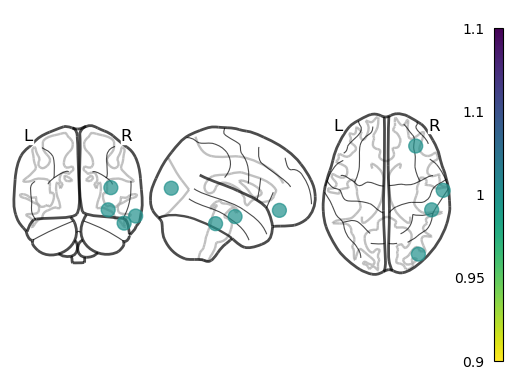

In [5]:
import pickle

fname = '../../data/fmri-FC-slim.pkl'
fmriDict = None

with open(fname, 'rb') as f:
    fmriDict = pickle.load(f)
    
print(fmriDict.keys())

In [6]:
# Package fMRI data into data matrix and response variables

import numpy as np

keys = list(fmriDict['groupsNormalDiagMap'].keys())
y = [fmriDict['groupsNormalDiagMap'][key] for key in keys]
y = np.array(y).astype('int')
X = [fmriDict['FC-slim'][fmriDict['subjNum2IdxMap'][key]] for key in keys]
X = np.stack(X)
X = np.expand_dims(X, 1)
print(X.shape)
print(y.shape)

(66, 1, 34716)
(66,)


In [7]:
import sys

sys.path.append('../../LatentSimilarity')

from latsim import LatSim
from latsim.util import getAvg, validate, getSparseLoss

print('Complete')

Complete


In [9]:
import sys

sys.path.append('../..')

from imagenomer.main import Analysis, JsonData
from imagenomer.metadata import get_power_community_metadata
from imagenomer.similarity import get_latsim_similarity

a,b = np.triu_indices(264,1)
idcs = np.arange(34716)

labels = [f'{a[i]}-{b[i]}' for i in idcs]

print(labels[0:10])
print(labels[-10:])

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

mseLoss = nn.MSELoss()
ceLoss = nn.CrossEntropyLoss()

nRuns = 10

tot = []

modelName = 'LatentSimilarity'
nEpochs = 200
pPeriod = 5
thresh = 0.01
binParam = 0
L2 = 0
DP = 0.2
EDP = 0.2
lr = 1e-1

# Create analysis
model = f'{modelName} EntropyReg={binParam} L2={L2} DP={DP} EDP={EDP} lr={lr}'
desc = 'normal(1) vs. fibromyalgia(0) rest fMRI only, model W'
analysis = Analysis(desc=f'{desc}: {model}', 
                    host='localhost', 
                    port=8000, 
                    label_names=['Flattened Indices', 'ROIs'],
                    labels=[list(range(X.shape[-1])), labels])

# Send community metadata
meta = get_power_community_metadata(analysis)
r = meta.post()
print(r.content)

for run in range(nRuns):
    FCslim = fmriDict['FC-slim']
    subjNum2Idx = fmriDict['subjNum2IdxMap']

    # Make a random split
    idcs = np.arange(66)
    np.random.shuffle(idcs)
    trainIdcs = idcs[:50]
    testIdcs = idcs[50:]
    Xtr = X[trainIdcs]
    Xt = X[testIdcs]
    ytr = y[trainIdcs]
    yt = y[testIdcs]
    
    # Standardize - good for some datasets but not for others
    mu = np.mean(Xtr, axis=0, keepdims=True)
    sd = np.std(Xtr, axis=0, keepdims=True)
    Xtr = (Xtr-mu)/sd
    Xt = (Xt-mu)/sd
    
    Xtrain_t = torch.from_numpy(Xtr).float().cuda()
    Xtest_t = torch.from_numpy(Xt).float().cuda()
    ytrain_t = [F.one_hot(torch.from_numpy(ytr)).float().cuda()]
    ytest_t = [F.one_hot(torch.from_numpy(yt)).float().cuda()]
    X_t = torch.cat([Xtrain_t, Xtest_t])
    y_t = [torch.cat([ytrain_t[0], ytest_t[0]])]
    
    # HC and FM subjects
    HCtrain = np.where(ytr == 1)[0]
    FMtrain = np.where(ytr == 0)[0]
    HCtest = Xtr.shape[0] + np.where(yt == 1)[0]
    FMtest = Xtr.shape[0] + np.where(yt == 0)[0]
    
    sim = LatSim(1, Xtrain_t, dp=DP, edp=EDP, wInit=1e-4, dim=1, temp=1)
    optim = torch.optim.Adam(sim.parameters(), lr=lr, weight_decay=L2)
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = sim(Xtrain_t, ytrain_t)
        res = getAvg(res)[0]
        loss = []
        if ytrain_t[0].ndim > 1:
            loss.append(ceLoss(res, ytrain_t[0]))
        else:
            loss.append(mseLoss(res, ytrain_t[0]))
        if binParam is not None and binParam != 0:
            loss.append(getSparseLoss(sim, binParam))
        sum(loss).backward()
        optim.step()
#         if epoch % pPeriod == 0 or epoch == nEpochs-1 or all([ls < thresh for ls in loss]):
#             print(f'epoch {epoch} loss={loss}')
            
    ntr = ytrain_t[0].shape[0]
    ntst = ytest_t[0].shape[0]
    acc = validate(sim, X_t, y_t, np.arange(ntr,ntr+ntst))[0]
    _, es = sim(X_t, y_t, np.arange(ntr,ntr+ntst), return_es=True)
    
    print(f'{run}. {acc}')
    
    tot.append(float(acc))
    
    # Difference in w*FC between cohorts
    w = np.sum(np.abs(sim.w[0,0].detach().cpu().numpy()), axis=1).astype('float64')
    wHC = np.mean(np.expand_dims(w,0)*Xtr[HCtrain,0], axis=0)
    wFM = np.mean(np.expand_dims(w,0)*Xtr[FMtrain,0], axis=0)
    w = wHC-wFM
    w = w

    # Send Weights
    jsonObj = {
        'Compare': desc,
        'Model': modelName,
        'Accuracy': float(acc),
        'Train': [HCtrain.shape[0],FMtrain.shape[0]],
        'Test': [33-HCtrain.shape[0],33-FMtrain.shape[0]],
        'Weights': list(w) #list(connWmultFC.astype('float64')) 
    }
    
    dat = JsonData(analysis)
    dat.update(jsonObj)
    r = dat.post()
    print(dat.dict['runid'])
    print(r.content)
    
    # Send Similarity
    jsonsim = get_latsim_similarity(analysis, dat, es[0][0].detach().cpu().numpy(),
                                    from_ids=list(np.array(keys)[idcs]),
                                    to_ids=list(np.array(keys)[idcs]),
                                    groups={
                                        'HCtrain': list(HCtrain), 
                                        'FMtrain': list(FMtrain),
                                        'HCtest': list(HCtest),
                                        'FMtest': list(FMtest)
                                    })
    r = jsonsim.post()
    print(r.content)
    
#     print(r[:ntr])
#     print(r[ntr:])
    
tot = np.array(tot)
print(np.mean(tot))
print(np.std(tot))

['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10']
['259-260', '259-261', '259-262', '259-263', '260-261', '260-262', '260-263', '261-262', '261-263', '262-263']
b'Success'
0. 0.6875
0
b'Success'
b'Success'
1. 0.4375
1
b'Success'
b'Success'
2. 0.625
2
b'Success'
b'Success'
3. 0.6875
3
b'Success'
b'Success'
4. 0.8125
4
b'Success'
b'Success'
5. 0.75
5
b'Success'
b'Success'
6. 0.3125
6
b'Success'
b'Success'
7. 0.8125
7
b'Success'
b'Success'
8. 0.75
8
b'Success'
b'Success'
9. 0.875
9
b'Success'
b'Success'
0.675
0.16723860200324564


In [9]:
print(keys)

['002', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '028', '029', '030', '031', '032', '033', '034', '036', '037', '038', '039', '040', '042', '043', '044', '045', '046', '047', '049', '050', '052', '053', '054', '055', '056', '058', '059', '060', '061', '062', '063', '064', '066', '068', '069', '070', '072', '073', '074', '075', '076', '077']
